# Creating a General Purpose Potential for Molecular Crystals - Part 1

This notebook is used to create a general purpose GAP potential for molecular crystals. The potential is built on PBE-D3 data from short PIMD simulations of 2238 different molecular crystals. Please note that it has a high (~150 GB) memory requirement to run fully.

In this part of the notebook: 
- The geometry-optimised and thermalised configurations datasets are combined
- The combined dataset is FPS-sorted *per crystal*
- The first 11 FPS-sorted configurations per crystal are split into training, validation, and test sets
- Composition matrices (X) and vectors of corresponding energies (y) are made
- A dressed-atom model is created

### Importing modules and defining functions

In [1]:
#Import modules
from matplotlib import pylab as plt
from tqdm import tqdm
import itertools

import pickle
import numpy as np
from sklearn import linear_model
import skcosmo.feature_selection
from skcosmo.feature_selection import FPS
from skcosmo.sample_selection import PCovCUR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time

from rascal.models import KRR
from rascal.utils import dump_obj, load_obj

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj
from rascal.utils import get_score
from rascal.utils.io import load_json, dump_json


In [2]:
#Define functions
def do_fps(x, d=0):
    """
    Function for performing farthest-point-sampling for a given feature matrix.
    d gives the number of farthest-point-sampled feature vectors that will be outputted. 
    If d==0, the entire set will be FPS-sorted.
    Returns the FPS-sorted IDs, as well as the FPS distances.
    """
    if d == 0 : d = len(x)
    n = len(x)
    iy = np.zeros(d, int)
    # faster evaluation of Euclidean distance
    n2 = np.sum(x**2,axis=1)
    iy[0] = 0
    dl = n2 + n2[iy[0]] - 2* np.dot(x, x[iy[0]])
    dss = []
    for i in range(1,d):
        iy[i] = np.argmax(dl)
        nd = n2 + n2[iy[i]] - 2*np.dot(x,x[iy[i]])
        dl = np.minimum(dl, nd)
        dss.append(max(dl))
    return iy,dss

def get_forces(frames):
    frc = np.zeros((np.sum([len(frm) for frm in frames]),3))
    iat = 0
    for ifrm,frm in enumerate(frames):
        frc[iat:iat+len(frm)] = frm.get_array('forces') 
        iat += len(frm)
    return frc

#Get feature vectors for a list of atoms objects. This requires soap to be set, as well as all_species, which is
#a list with one atoms object that contains all species HCNO
def get_features(atoms_objects, batch_size=1000):
    struct_feat=[] #create empty feature vector of n_structures x n_features
    for i in range(int(len(atoms_objects)/batch_size+0.9999)): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=all_species.copy() #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species.copy()[0]):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

### Reading Databases
This reads in the CSD-10k dataset. The geop dataset has only one (the geometry-optimised) configuration per crystal, with the MD dataset having 101 (1 geop + 100 thermalised) configurations per crystal. This totals around 225k structures.

In [3]:
# Load databases
geop = read('raw_data/CSD-10k_geop_hcno_w_kpts.xyz', ':')
md = read('raw_data/CSD-10k_md_hcno_w_kpts.xyz', ':')

KeyboardInterrupt: 

### Combining, saving, and (re-)loading databases
The two databses are combined and saved. Please note that the geometry-optimised configuration in the MD database is removed, and the geometry-optimised configuration from the geop database is added. This is done to avoid numerical errors.

In [ ]:
#Adding names of crystal structures to the geop dataset, and creating a new database (dictionary) containing
#geop and md structures

db = {} #create dictionary where the keys are the names of the crystals, and the values are the atoms objects of all configurations of the crystal (102 total)
vol = [] #create list of crystal volumes
name = [] #create list of crystal names
for frm in md[::101]: #iterate over crystals in dataset of MD (non-geop) structures (101 configurations per crystal)
    name.append(frm.info['name'].split(sep='_')[0]) #get crystal name from frame
    vol.append(frm.get_volume()) #append volume to list
print("Added volume info to geop frames. Created arrays of crystal names and volumes.") 

for ifrm,frm in enumerate(geop):
    idx = np.where(vol == frm.get_volume())[0][0] #match geop frame volume to the volume index in the volume list
    frm.info['name'] = name[idx] #use index of volume list to get the name of the crystal, and add it to the geop frame
    db[name[idx]] = [frm] #Add geop frame to dictionary 

print("Added geop frames to database. Now adding MD frames.")

for i in tqdm(range(int(len(md)/101))): #get number of crystals in md database
    j = i*101 #get number of structures in md database
    for ifrm,frm in enumerate(geop):
        if md[j].get_volume() == frm.get_volume(): #if geop volume matches volume in md database
            db[frm.info['name']] += md[j+1:j+101] #add all 100 md configs (excluding the initial config, which matches the geometry optimised one) to the correct geop structure in the database
            #note: all configs for a certain crystal are in order, which is why j:j+101 are all configs of the same crystal
print("Done.")  

In [ ]:
#Save full database (Geop + 100 MD structures)
save_file = open("raw_data/CSD-10k_combined_w_kpts.pickle", "wb") #save database to pickle file
pickle.dump(db, save_file)
save_file.close()

In [3]:
#(re-)Load database of 100 MD + geop structure
dictionary_file = open("raw_data/CSD-10k_combined_w_kpts.pickle", "rb") #open saved pickle database
db = pickle.load(dictionary_file)
name=list(db.keys())

## FPS-sort configurations of each crystal
The MD dataset consists of configurations obtained over short (250 fs or so) simulations. Therefore, some of the structures are highly correlated and there is likely to be a fair amount of redundancy in the dataset. For this reason, the 101 configurations of each structure are FPS sorted, and the 11 most diverse (geop + 10 MD) structures are taken for building the model, validation and testing.

### Defining SOAP hyperparameters
For the purposes of FPS-sorting, the hyperparameters chosen need not be conservative, as even a low choice of basis functions is likely to effectively FPS-sort the structures.

In [5]:
#Define soap hyperparameters
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=6, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=2
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False #don't care about forces right now
              )
soap = SphericalInvariants(**hypers)


### FPS-sort configurations per crystal
This uses the FPS function of skcosmo. Feature vectors are produced for each atom in a configuration, and are subsequently averaged across all atoms of the configuration in order to obtain a feature vector for the configuration. These average feature vectors are then FPS-sorted across configurations of a single crystal.
The FPS-sorted database (~25k structures) are then saved, and can be re-loaded to save time. 

In [10]:
# FPS-sort the database using SOAP feature vectors. Only 11 structures (Geop + 10 MD) were sorted and saved per crystal.
db_fps = [] #create new database (array) of FPS-sorted structures for each crystal

selector = FPS(n_to_select=11) #select 11 farthest-point-sampled structures (for each crystal)
for n in tqdm(name): #iterate over names (crystals) in the database
    for frm in db[n]:
        frm.wrap(eps=1e-13) #wrap atoms in unit cell
    manager = soap.transform(db[n]) #calculate soap features for each structure in the crystal

    env_feat = manager.get_features(soap) #get feature vectors (one for each atom of each configuration, concatenated)
    nat = int(env_feat.shape[0]/102) #get number of atoms
    struct_feat = np.zeros((101,env_feat.shape[1])) #create empty (zero) matrix of n_frames x n_features
    for i in range(101):
        struct_feat[i] = np.mean(env_feat[i*nat:(i+1)*nat],axis=0) #get the average feature vector across all atoms 
        # of a certain configuration, and add this average feature vector (n_features) to the new (struct_feat) 
        # matrix (i.e. it will have an average feature vector for each configuration/frame)
    
    selector.fit(struct_feat.T) #FPS sort according to frames (you need to transpose the matrix for this, otherwise it'll sort according to features)
    fps_feat = selector.transform(struct_feat.T).T #or does this FPS sort??
    for vvec in fps_feat:
        for ivec,vec in enumerate(struct_feat):
            if np.linalg.norm(vvec - vec) < 1e-16:
                db_fps.append(db[n][ivec]) #append fps-sorted configs/frames for each structure to a new database
                

  0%|          | 0/2238 [00:00<?, ?it/s]

#### Save and (re-load) FPS per crystal database

In [11]:
#Save FPS-sorted database (11 structures per crystal)
np.save('raw_data/CSD-10k_per_crystal_fps_w_kpts', db_fps)

/home/vprincip/code/miniconda3/envs/genshift/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [4]:
#Load FPS-sorted database
db_fps=np.load('raw_data/CSD-10k_per_crystal_fps_w_kpts.npy', allow_pickle=True)
all_species=[db_fps[16]]

## Create training, validation, and testing databases
The ~25k FPS-sorted (per crystal) configurations are split into training, validation, and testing databses. Datasets are created in a randomised fashion. 1000 configurations are chosen for validation and testing, each, with the rest being left for training purposes.  

In [5]:
#Split frames into train, validation, and test sets
ids = np.arange(len(db_fps)) #create IDs for each frame
np.random.seed(0) #Give the shuffle function a seed so that the output of the shuffle function is the same
                  # every time the cell is run  
np.random.shuffle(ids) #shuffle IDs

test_set=[db_fps[idx] for idx in ids[:1000]] #1000 test configs
val_set=[db_fps[idx] for idx in ids[1000:2000]] #1000 validation configs
train_set=[db_fps[idx] for idx in ids[2000:]] #Rest is used for training

In [27]:
#Save training, validation, and testing datasets
np.save('raw_data/CSD-10k_train_set', np.asarray(train_set, dtype='object')) #save training set
np.save('raw_data/CSD-10k_val_set', np.asarray(val_set, dtype='object')) #save validation set
np.save('raw_data/CSD-10k_test_set', np.asarray(test_set, dtype='object')) #save test set

## FPS-sort all training structures
FPS-sort training structures, without discriminating between crystals. This means that the first 2238 structures are therefore (very) likely to contain one configuration per crystal. FPS sorting in this case is done using the `do_fps` function defined at the top of the notebook. 

In [47]:
#Get feature vectors for training database
struct_feat=np.zeros((len(train_set), 2520)) #create empty feature vector of n_structures x n_features
for i in tqdm(range(int(len(train_set)/2000+0.9999))): #Get feature vectors in batches of 1000
    for frm in train_set[i*2000:(i+1)*2000]:
        frm.wrap(eps=1e-13) #wrap atoms in unit cell
    frames=[train_set[0]] #add initial frame with all species
    frames.extend(train_set[i*2000:(i+1)*2000]) #extend initial frame with frames of batch
    manager = soap.transform(frames) #calculate soap features for all structures in batch
    env_feat_batch = manager.get_features(soap)[len(train_set[0]):] #get feature vectors for all structures in batch
    # (having removed the initial frame)
    atom_counter=0 #count atoms
    for ifrm,frm in enumerate(train_set[i*2000:(i+1)*2000]): #iterate over frames in batch
        nat=len(frm) #count atoms in frame
        struct_feat[i*2000+ifrm] = np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0) #average vectors
        # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
        atom_counter+=nat #add atoms to counter
        

  0%|          | 0/12 [00:00<?, ?it/s]

In [48]:
#Save feature vectors
np.save('raw_data/CSD-10k_features_train_set', struct_feat)

In [39]:
#Load feature vectors
struct_feat = np.load('raw_data/CSD-10k_features_train_set.npy')

### FPS-sort structures
The IDs and distances of FPS-sorted structures are computed, saved, and (re-)loaded below.

In [ ]:
#FPS-sort feature vectors
fps_ids, fps_dist = do_fps(struct_feat)

#### Save and (re-)load FPS-sorted training structures

In [10]:
#Save FPS IDs and FPS distances
np.save('raw_data/CSD-10k_train_set_FPS_ids', fps_ids)
np.save('raw_data/CSD-10k_train_set_FPS_dist', fps_dist)

In [3]:
fps_ids = np.load('raw_data/CSD-10k_train_set_FPS_ids.npy')
fps_dist = np.load('raw_data/CSD-10k_train_set_FPS_dist.npy')

In [86]:
#Compute and save FPS-ordered training set
train_set_FPS = [train_set[i] for i in fps_ids]
np.save('model_data/train_set_FPS', np.asarray(train_set_FPS, dtype='object'))

The plot below shows the FPS distances between structures, which decreases as you move along the FPS-sorted training strucutres. 

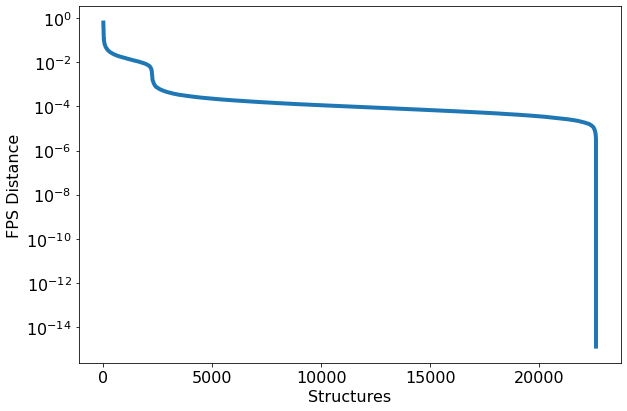

In [25]:
plt.figure(figsize=(9,6))
plt.rcParams.update({'font.size': 16})
plt.xlabel('Structures')
plt.ylabel('FPS Distance')
plt.plot(fps_dist, lw = 4)
plt.yscale('log')
plt.tight_layout()

## Create dressed atom energies model (i.e. baseline)
A simple dressed atom model (baseline) is created. This is done so that the "atomic" energies are not learned, but rather the "binding energies" of each crystal is learned. 

### Create matrices (X) and vectors (y)
Matrices (X) are created of structures where the 'features' are the number of atoms of each species for each structure. The vectors (y) contain the total energies of each structures. Matrices and vectors are created for all structures, validation structures, and test structures.

In [7]:
#Create a matrix of n_structures x n_atoms_per_species (i.e. 2238 x 4 matrix), and a vectors with energies of structures
db_all = []
[db_all.extend(db[n]) for n in db]

X_all = np.zeros((len(db_all),4),dtype=int) #create matrix
y_all = np.zeros(len(db_all)) #create vector
for ifrm, frm in enumerate(db_all):
    symbols=frm.get_atomic_numbers() #get atomic numbers from frame
    y_all[ifrm]=(frm.info['energy']) #get energy from frame
    X_all[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]] #create vector of [n_H, n_C, n_N, n_O] and add to matrix

np.save('raw_data/X_all', X_all) #Save matrix
np.save('raw_data/y_all', y_all) #Save vector

In [8]:
#Create same as above but for train set
X_train = np.zeros((len(train_set),4),dtype=int)
y_train = np.zeros(len(train_set))
for ifrm, frm in enumerate(train_set):
    symbols=frm.get_atomic_numbers()
    y_train[ifrm]=(frm.info['energy'])
    X_train[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]

np.save('raw_data/X_train', X_train) #Save matrix
np.save('raw_data/y_train', y_train) #Save vector

In [9]:
#Create same as above but for validation set
X_val = np.zeros((len(val_set),4),dtype=int)
y_val = np.zeros(len(val_set))
for ifrm, frm in enumerate(val_set):
    symbols=frm.get_atomic_numbers()
    y_val[ifrm]=(frm.info['energy'])
    X_val[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]

np.save('raw_data/X_val', X_val) #Save matrix
np.save('raw_data/y_val', y_val) #Save vector

In [10]:
#Create same as above but for test set
X_test = np.zeros((len(test_set),4),dtype=int)
y_test = np.zeros(len(test_set))
for ifrm, frm in enumerate(test_set):
    symbols=frm.get_atomic_numbers()
    y_test[ifrm]=(frm.info['energy'])
    X_test[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]

np.save('raw_data/X_test', X_test) #Save matrix
np.save('raw_data/y_test', y_test) #Save vector

### Create model

In [12]:
#Create a simple model in order to baseline energies (i.e. get a model that predicts per-atom-per-species energies)
# This is done so that the MLP that will be created is centred around zero and independent of system size
mlr = Ridge(alpha=1E-4, fit_intercept=False) #Don't fit intercept
mlr.fit(X_all, y_all)
print("Intercept: ", mlr.intercept_)
print("Coefficients:",mlr.coef_)

Intercept:  0.0
Coefficients: [ -16.46576331 -154.71870284 -383.3436899  -566.22750974]


In [23]:
#Save model
with open('raw_data/mlr.pkl','wb') as f:
    pickle.dump(mlr, f)

### Test model on validation set

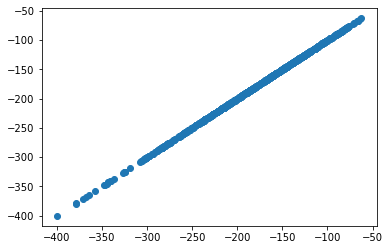

In [18]:
#Plot training (original) energies against predicted energies
plt.scatter(y_val/np.sum(X_val,axis=1),mlr.predict(X_val)/np.sum(X_val,axis=1))

The histogram below shows the per-atom errors in energy predictions for the validation dataset. It is these (binding) energies that are going to be learned by the new model

RMSE:  0.10683691583797131 eV per atom


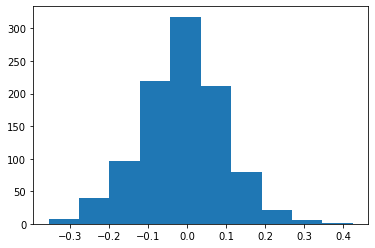

In [25]:
plt.hist(y_val/np.sum(X_val,axis=1)-mlr.predict(X_val)/np.sum(X_val,axis=1)) #plot histogram
rmse = np.sqrt(np.mean((y_val/np.sum(X_val,axis=1)-mlr.predict(X_val)/np.sum(X_val,axis=1))**2))
print("RMSE: ", rmse, "eV per atom")